In [16]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

<h2> Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [9]:
# -*- coding: utf-8 -*-

from array import array


def lcsubstrings(seq1, seq2, positions=False):
	"""Find the longest common substring(s) in the sequences `seq1` and `seq2`.
	
	If positions evaluates to `True` only their positions will be returned,
	together with their length, in a tuple:
	
		(length, [(start pos in seq1, start pos in seq2)..])
	
	Otherwise, the substrings themselves will be returned, in a set.
	
	Example:
	
		>>> lcsubstrings("sedentar", "dentist")
		{'dent'}
		>>> lcsubstrings("sedentar", "dentist", positions=True)
		(4, [(2, 0)])
	"""
	L1, L2 = len(seq1), len(seq2)
	ms = []
	mlen = last = 0
	if L1 < L2:
		seq1, seq2 = seq2, seq1
		L1, L2 = L2, L1
	
	column = array('L', range(L2))
	
	for i in range(L1):
		for j in range(L2):
			old = column[j]
			if seq1[i] == seq2[j]:
				if i == 0 or j == 0:
					column[j] = 1
				else:
					column[j] = last + 1
				if column[j] > mlen:
					mlen = column[j]
					ms = [(i, j)]
				elif column[j] == mlen:
					ms.append((i, j))
			else:
				column[j] = 0
			last = old
	
	if positions:
		return (mlen, tuple((i - mlen + 1, j - mlen + 1) for i, j in ms if ms))
	return set(seq1[i - mlen + 1:i + 1] for i, _ in ms if ms)


In [10]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def getTokenFeatures(q1, q2):
    
    token_features = [0.0] * 10;
    
    #getting tokens from question1 and question2
    tokens_q1 = q1.split();
    tokens_q2 = q2.split();
    
    #if there are no words in question1 and question2 then return 0 for all features;
    if len(tokens_q1) == 0 or len(tokens_q2) == 0:
        return token_features
    
    #getting words from tokens which are not stop words
    words_q1 = set([w for w in tokens_q1 if w not in STOP_WORDS]);
    words_q2 = set([w for w in tokens_q2 if w not in STOP_WORDS]);
    
    #getting stop words from tokens
    stop_words_q1 = set([w for w in tokens_q1 if w in STOP_WORDS]);
    stop_words_q2 = set([w for w in tokens_q2 if w in STOP_WORDS]);
    
    #gettting common words count from question pair
    common_words_count = len(words_q1.intersection(words_q2))
    
    #getting common tokens count from question pair
    common_tokens_count = len(set(tokens_q1).intersection(set(tokens_q2)));
    
    #getting common stop words count from question pair
    common_stop_words_count = len(stop_words_q1.intersection(stop_words_q2));
    
    #creating feature cwc_min
    token_features[0] = common_words_count / (min( len(words_q1), len(words_q2) ) + SAFE_DIV);
    
    #creating feature cwc_max
    token_features[1] = common_words_count / (max( len(words_q1), len(words_q2) ) + SAFE_DIV);
    
    #creating feature csc_min
    token_features[2] = common_stop_words_count / (min( len(stop_words_q1), len(stop_words_q2) ) + SAFE_DIV);
    
    #creating feature csc_max
    token_features[3] = common_stop_words_count / (max( len(stop_words_q1), len(stop_words_q2) ) + SAFE_DIV);
    
    #creating feature ctc_max
    token_features[4] = common_tokens_count / (min( len(stop_words_q1), len(stop_words_q2) ) + SAFE_DIV);
    
    #creating feature ctc_min
    token_features[5] = common_tokens_count / (max( len(stop_words_q1), len(stop_words_q2) )+ SAFE_DIV);
    
    #creating feature last_word_eq
    token_features[6] = int(tokens_q1[-1] == tokens_q2[-1]);
    
    #creating feature first_wor_eq
    token_features[7] = int(tokens_q1[0] == tokens_q2[0]);
    
    #creating feature abs_len_diff
    token_features[8] = abs( len(tokens_q1) - len(tokens_q2) )
    
    #creating feature mean_len 
    token_features[9] = (len(tokens_q1) + len(tokens_q2))/2;
    
    return token_features;

def getFuzzyFeatures(x):
    #http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://github.com/seatgeek/fuzzywuzzy
    fuzzy_features = [0.0] * 4;
    
    #creating feature token_set_ratio
    fuzzy_features[0] = fuzz.token_set_ratio(x["question1"], x["question2"])
    
    #creating feature token_sort_ratio
    fuzzy_features[1] = fuzz.token_sort_ratio(x["question1"], x["question2"])
    
    #creating feature fuzz_ratio
    fuzzy_features[2] = fuzz.QRatio(x["question1"], x["question2"])
    
    #creating feature fuzz_partial_ratio
    fuzzy_features[3] = fuzz.partial_ratio(x["question1"], x["question2"])
    
    return fuzzy_features;

def get_longest_substr_ratio(a, b):
    strs = list(lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features(df):
    token_features = df.apply(lambda x: getTokenFeatures(x['question1'], x['question2']), axis=1);
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    
    fuzzy_features = df.apply(lambda x: getFuzzyFeatures(x), axis=1);
    
    df["token_set_ratio"]  = list(map(lambda x: x[0], fuzzy_features));
    df["token_sort_ratio"] = list(map(lambda x: x[1], fuzzy_features));
    df["fuzz_ratio"]       = list(map(lambda x: x[2], fuzzy_features));
    df["fuzz_partial_ratio"]    = list(map(lambda x: x[3], fuzzy_features));
    
    #creating feature longest_substr_ratio
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df;

In [11]:
#creating advance features for train
if os.path.isfile('nlp_features_train.csv'):
    X_train = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    X_train.fillna('')
else:
    print("Extracting features for train:")
    X_train = pd.read_csv("train_basic_features.csv",encoding='latin-1')
    X_train['question1'] = X_train["question1"].fillna("")
    X_train['question2'] = X_train["question2"].fillna("")
    X_train = extract_features(X_train)
    X_train.to_csv("nlp_features_train.csv", index=False)
X_train.head(2)

Extracting features for train:


,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,394633,185833,3212,one amp equals how many watts,what is the difference between amps watts and...,2,2,30,53,7,...,0.199996,0.0,0.0,3.0,7.5,42,42,37,50,0.225806
1,339905,467594,467595,what is dmart own pentagon retail model,what is dmart own triangle retail model,1,1,40,40,8,...,1.999933,1.0,1.0,0.0,7.0,87,79,87,88,0.439024


In [12]:
#creating advance features for train
if os.path.isfile('nlp_features_test.csv'):
    X_test = pd.read_csv("nlp_features_test.csv",encoding='latin-1')
    X_test.fillna('')
else:
    print("Extracting features for test:")
    X_test = pd.read_csv("test_basic_features.csv",encoding='latin-1')
    X_test['question1'] = X_test["question1"].fillna("")
    X_test['question2'] = X_test["question2"].fillna("")
    X_test = extract_features(X_test)
    X_test.to_csv("nlp_features_test.csv", index=False)
X_test.head(2)

Extracting features for test:


,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,237030,33086,348102,how can i stop playing video games,should i stop playing video games with my child,1,1,35,48,8,...,1.249969,0.0,0.0,2.0,8.0,87,69,72,86,0.777778
1,247341,73272,8624,who is better donald trump or hillary clinton,why is hillary clinton a better choice than do...,8,3,46,57,9,...,1.499963,0.0,0.0,2.0,9.0,92,83,50,50,0.361702


In [13]:
#creating advance features for train
if os.path.isfile('nlp_features_cv.csv'):
    X_cv = pd.read_csv("nlp_features_cv.csv",encoding='latin-1')
    X_cv.fillna('')
else:
    print("Extracting features for cv:")
    X_cv = pd.read_csv("cv_basic_features.csv",encoding='latin-1')
    X_cv['question1'] = X_cv["question1"].fillna("")
    X_cv['question2'] = X_cv["question2"].fillna("")
    X_cv = extract_features(X_cv)
    X_cv.to_csv("nlp_features_cv.csv", index=False)
X_cv.head(2)

Extracting features for cv:


,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,204827,307828,307829,how does distilled water differ from spring wa...,why is distilled water better than spring water,1,2,50,48,9,...,0.999967,1.0,0.0,0.0,8.0,71,69,75,77,0.367347
1,35012,64051,64052,how do i quit watching porn and focus in life,why did you quit watching porn,1,1,46,31,11,...,0.599988,0.0,0.0,4.0,8.0,75,56,61,77,0.625000


<h3>Analysis of extracted features </h3>

<h4> Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words
- It also shows whether words in questions are relavent in finding duplicacy.

In [14]:
df = X_train
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0];

p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten();
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten();

print('Number of data points in class 1 (duplicate pairs): ', len(p));
print('Number of data points in class 2 (nonduplicate pairs): ', len(n));

Number of data points in class 1 (duplicate pairs):  145986
Number of data points in class 2 (nonduplicate pairs):  250218


#### Plotting wordCloud for duplicates question pair

In [17]:
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

Word Cloud for Duplicate Question pairs


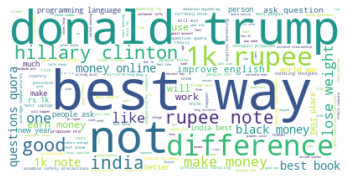

In [18]:
wc = WordCloud(background_color="white", max_words=len(p), stopwords=stopwords)
words = '';
for w in p:
    words = words + w + ' ';
wc.generate(words)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Plotting wordCloud for non-duplicates question pair

Word Cloud for Duplicate Question pairs


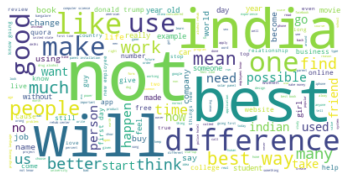

In [19]:
wc = WordCloud(background_color="white", max_words=len(n), stopwords=stopwords)
words = '';
for w in n:
    words = words + w + ' ';
wc.generate(words)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Pair plot for some advanced features

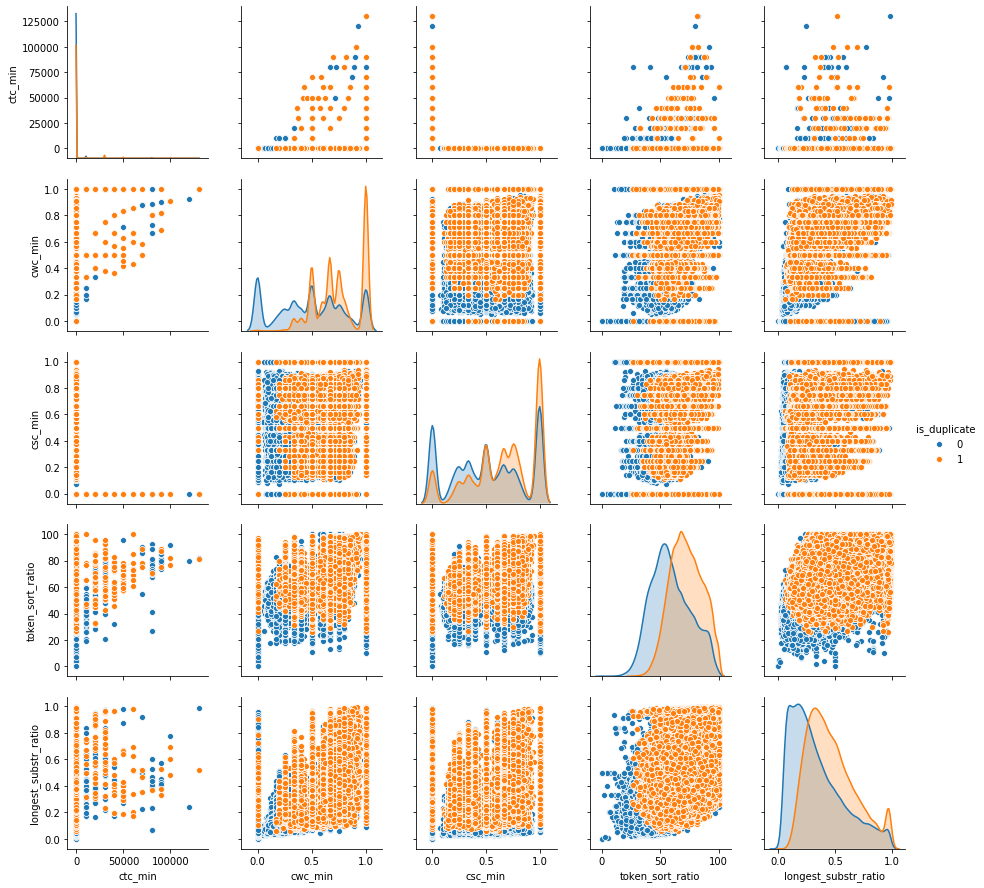

In [20]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'longest_substr_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'longest_substr_ratio'])
plt.show()

### Performing Univariate Analysis

Feature: token_set_ratio

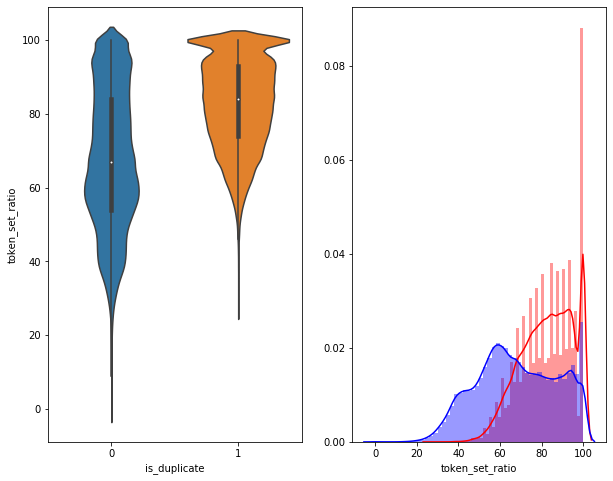

In [21]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

Feature: fuzz_ratio

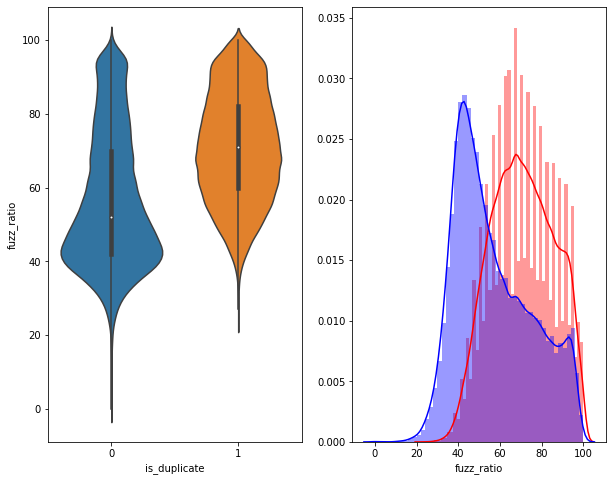

In [22]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

Feature: mean_len

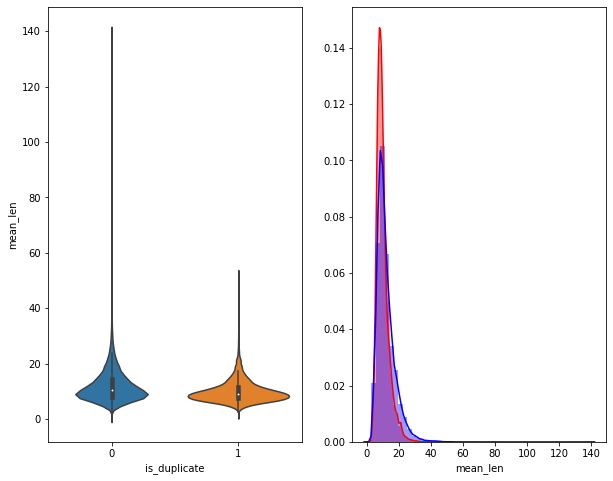

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'mean_len', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['mean_len'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['mean_len'][0:] , label = "0" , color = 'blue' )
plt.show()

### Visualization using t-SNE: reducing 15 advanced features to 2-dimension and 3-dimension for visualization

In [24]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:10000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [25]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.312s...
[t-SNE] Computed neighbors for 10000 samples in 3.403s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.102425
[t-SNE] Computed conditional probabilities in 1.594s
[t-SNE] Iteration 50: error = 96.3986664, gradient norm = 0.0171279 (50 iterations in 18.784s)
[t-SNE] I

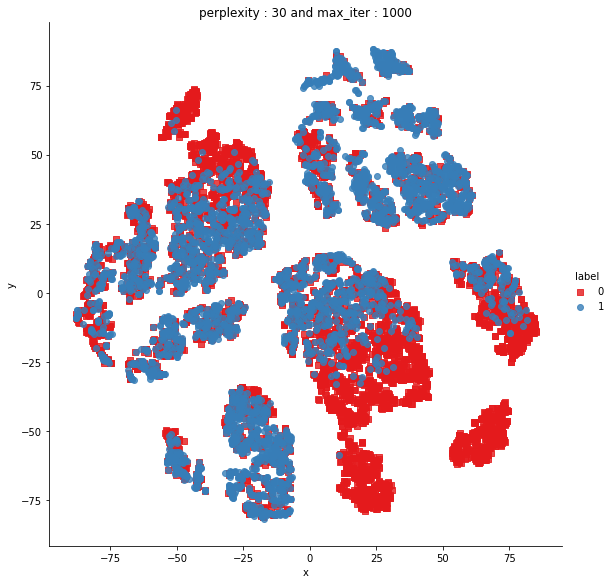

In [26]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [27]:

tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.056s...
[t-SNE] Computed neighbors for 10000 samples in 3.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.102425
[t-SNE] Computed conditional probabilities in 1.327s
[t-SNE] Iteration 50: error = 97.3157043, gradient norm = 0.0080675 (50 iterations in 67.161s)
[t-SNE] I

In [28]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')